In [76]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as col
from tqdm import tqdm
from IPython.display import clear_output
from scipy import optimize
import sympy as sm
import math

In [175]:
xcolor,ycolor,zcolor = 'r','b','g'
xycolor = 'purple'
defaultfigsize = (8,8)
largerfigsize = (16,8)
largererfigsize = (32,16)

In [98]:
def H(x):
    #Heaviside function
    if x > 0:
        return 1
    elif x<0:
        return 0
def h1(x):
    return x[0]
def h2(x):
    return x[1]
    
def H1(x):
    return H(h1(x))
def H2(x):
    return H(h2(x))

def PWS(v): # f1, f2, f3, f4
    return [np.array([1,1,1]),np.array([1,-1,v]),np.array([-1,+1,v]),np.array([-1,-1,1])]

def integrand(x,v):
    f_1,f_2,f_3,f_4 = f1(x,v),f2(x,v),f3(x,v),f4(x,v)
    return H1(x)*H2(x) * (f_1-f_2-f_3+f_4) + H1(x)*(f_3-f_1) + H2(x)*(f_2-f_1) + f_1 

def fx(x,v):
    return integrand(x,v)[0]#(-2 * H1(x) + 1)
def fy(x,v):
    return integrand(x,v)[1]#(-2 * H2(x) + 1)
def fz(x,v):
    return integrand(x,v)[2]#((1-v)*(2*H1(x)*H2(x) - H1(x) - H2(x)) +1)

def f1(x,v):
    return PWS(v)[0]
def f2(x,v):
    return PWS(v)[1]
def f3(x,v):
    return PWS(v)[2]
def f4(x,v):
    return PWS(v)[3]



# Euler Method

In [79]:
def vector(x,v):
    vect = integrand(x,v)#np.array([fx(x,v),fy(x,v),fz(x,v)])
    return vect

def euler_model(tstep,T,v,x0=(1,2,1)):
    n = int(T/tstep)
    tt = np.linspace(0, T, n)
    yy = np.zeros((n,len(x0)))+x0
    for i,t in enumerate(tqdm(tt,position=0,leave = False,desc = 'Euler model')):
        yy[i,:] = yy[i-1,:] + tstep*vector(yy[i-1],v)
    return yy

31.41592653589793 62.83185307179586
31 62


-0.9867606471697479

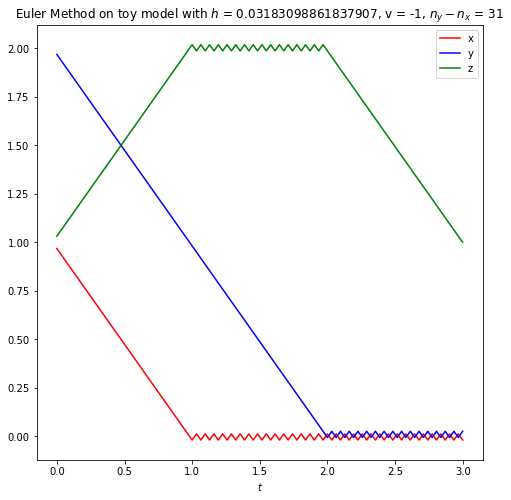

In [440]:
# Initial value
x0 = 1,2,1
# Max time
T = 3
# time step (h in the notes). Very important that tstep doesn't divide x0[0],x0[1]
tstep = 10**-1/np.pi
# z component of vector field in R2 and R3
v = -1
# Number of iterations
n = int(T/tstep)

nx = int(x0[0]/tstep)
print(x0[0]/tstep,x0[1]/tstep)
ny = int(x0[1]/tstep)
print(nx,ny)

tt = np.linspace(0, T, n)
yyy = euler_model(tstep,T,v,x0)

fig, ax = plt.subplots(1, figsize=defaultfigsize)
# Plots of each component of particle over time
ax.plot(tt, yyy[:,0],color = xcolor,label='x')
ax.plot(tt, yyy[:,1],color = ycolor,label='y')
ax.plot(tt, yyy[:,2],color = zcolor,label='z')
ax.set_xlabel('$t$')
plt.title("Euler Method on toy model with $h$ = {}, v = {}, $n_y - n_x$ = {}".format(tstep,v,ny-nx))
ax.legend()

nume_doty3(yyy)

Plot of motion in $xy$-plane

Text(0, 0.5, 'y')

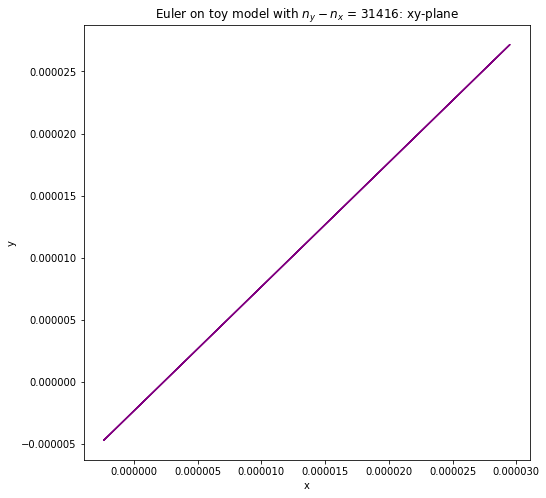

In [35]:
# Values come from previous simulation
plt.figure(figsize=defaultfigsize)
# Plot of y over x as it orbits around \Sigma
plt.plot(yyy[int(2*n/T):-1,0],yyy[int(2*n/T):-1,1],'-',color = xycolor)
plt.title("Euler on toy model with $n_y - n_x$ = {}: xy-plane".format(ny-nx))
plt.xlabel('x')
plt.ylabel('y')

# Bilinear Method

In [469]:
rd = 5 #decimal places to which a & b are rounded before duplicates are removed from newton raphson method 
#rd needs to be quite small, otherwise it counts 0.999999 as being a legal a or b
nr_num = 10 #number of starting points of newton raphson
nr_maxiter = 100 #num of iterations of newton raphson
error = 0.1
tan_tol = 0.1

def f_i(x,v):
    return H1(x)*H2(x)*(f4(x,v)-f3(x,v)-f2(x,v) + f1(x,v)) + H1(x)*(f3(x,v) - f1(x,v)) + H2(x)*(f2(x,v) - f1(x,v)) + f1(x,v)

def norm_components(x,v):
    w = np.zeros((5,3),dtype = np.float64) # In (4,2) works, but this keeps it consistent with Dieci notation
    
    w[1,1:3] = f1(x,v)[0:2]
    w[2,1:3] = f2(x,v)[0:2]
    w[3,1:3] = f3(x,v)[0:2]
    w[4,1:3] = f4(x,v)[0:2]

    return w

def assumptions(x):
    w = norm_components(x,v)
    #print(w)
    # Assumption (a)
    #for i in range(1,5):
     #   print('i=',i)
      #  print(H(w[i][1]),H1(x))
       # print(H(w[i][2]),H2(x))
        #print(x)
        #print('w',w[i,:])
        #if H(w[i][1]) == H1(x) and H(w[i][2]) == H2(x):
         #   print('fails')
          #  return False
    # Assumption (b,c)
    bc = 0
    combos_i = [(2,4),(1,3),(3,4),(1,2)]
    ks = [1,1,2,2]
    
    def tan(k,i,j,n):
        if n in [1,3]:
            i,j = j,i #spaghetti code to make it work
        def otherk(k):
            if k == 1:
                return 2
            elif k ==2:
                return 1
        return w[i][otherk(k)]/w[i][k] - w[j][otherk(k)]/w[j][k]
    
    for (n,(k,(i,j))) in enumerate(zip(ks,combos_i)):
        #print(tan(k,i,j,n))
        if w[i][k] > 0 and w[j][k] < 0 and tan(k,i,j,n) < 0:
            #print('ijk',i,j,k)
            #print(tan(k,i,j,n))
            #print('w',w)
            if -tan_tol <= tan(k,i,j,n) < tan_tol: #first order exit condition
                return False
            bc += 1
    return (bc > 0)

def solver(x,v,debug = 0,solve_method = 'nr'):
    w = norm_components(x,v)
    
    def poly_solver(x,v,debug=0):
        # in this case of h1 and h2, w_i^k will be the first and second components of f_i
        a,b = sm.symbols("a b")
        
        P = ((1-b)*w[1][2] + b *w[2][2])*((1-b)*w[3][1] + b *w[4][1]) - ((1-b)*w[3][2] + b *w[4][2])*((1-b)*w[1][1] + b *w[2][1])
        Q = ((1-a)*w[1][1] + a *w[3][1])*((1-a)*w[2][2] + a *w[4][2]) - ((1-a)*w[2][1] + a *w[4][1])*((1-a)*w[1][2] + a *w[3][2])
        
        asolns = sm.simplify(sm.solve(sm.simplify(Q),a,simplify = False,rational = False,quick=True))
        bsolns = sm.simplify(sm.solve(sm.simplify(P),b,simplify = False,rational = False,quick=True))
        print('a',asolns)
        print('b',bsolns)

        h = sm.simplify(((1-a)*w[1][1] + a* w[3][1])/ ( (1-a) *w[1][1]+ a* w[3][1]  - ((1-a)*w[2][1] + a * w[4][1] )))
        g = sm.simplify(((1-b)*w[1][2] + b* w[2][2])/ ( (1-b) *w[1][2]+ b* w[2][2]  - ((1-b)*w[3][2] + b * w[4][2] )))
        
            #remove all solutions not in (0,1)
        asolns = [a for a in asolns if 0<a<1]
        bsolns = [b for b in bsolns if 0<b<1]

        all_hasolns = [h.subs(a,asoln) for asoln in asolns]
        all_gbsolns = [g.subs(b,bsoln) for bsoln in bsolns]
        print('all_asolns, all_gbsolns :',asolns,all_gbsolns)
        print('all_bsolns, all_hasolns :',bsolns,all_hasolns)
        
        return asolns,bsolns
    
    def newton_raphson_solver(x,v,debug = 0):
    
        def P(b):
            return ((1-b)*w[1][2] + b *w[2][2])*((1-b)*w[3][1] + b *w[4][1]) - ((1-b)*w[3][2] + b *w[4][2])*((1-b)*w[1][1] + b *w[2][1])
    
        def Q(a):
            return ((1-a)*w[1][1] + a *w[3][1])*((1-a)*w[2][2] + a *w[4][2]) - ((1-a)*w[2][1] + a *w[4][1])*((1-a)*w[1][2] + a *w[3][2])
        def nr(poly,start):
            return optimize.newton(poly,start,maxiter = nr_maxiter)
    
        #round all the found asolns of Q to the nearest rd decimal place, and remove duplicates (should give list of size 2)
        asolns = list(set([round(nr(Q,a0),rd) for a0 in np.linspace(-1,2,nr_num)]))
        bsolns = list(set([round(nr(P,b0),rd) for b0 in np.linspace(-1,2,nr_num)]))
        return asolns,bsolns
    
    
    if solve_method == 'nr':
        solns = newton_raphson_solver
    if solve_method == 'poly':
        solns = poly_solver
    asolns,bsolns = solns(x,v)
    
    all_asolns,all_bsolns = asolns,bsolns #for debug

        
    def h(a):
        return ((1-a)*w[1][1] + a* w[3][1])/ ( (1-a) *w[1][1]+ a* w[3][1]  - ((1-a)*w[2][1] + a * w[4][1] ))
    def g(b):
        return ((1-b)*w[1][2] + b* w[2][2])/ ( (1-b) *w[1][2]+ b* w[2][2]  - ((1-b)*w[3][2] + b * w[4][2] ))
    
    #remove all solutions not in (0,1)
    asolns = [a for a in asolns if 0<a<1]
    bsolns = [b for b in bsolns if 0<b<1]

    hasolns = [h(asoln) for asoln in asolns]
    gbsolns = [g(bsoln) for bsoln in bsolns]
    for ha in hasolns:
        if math.isnan(ha):
            return asolns[0],bsolns[0]
    
    def rel_intersect(list1,list2,inter_error =1e-1):
    #returns the intersection of two sets, with elements equal within some error
    #(only works properly for sets of size 2)
        intersection = []
        for a in list1:
            for b in list2:
                if abs(a-b)<inter_error:
                    intersection += [a]
        return intersection
    #these should both be lists of size one
    legal_asolns = rel_intersect(asolns,gbsolns,error)
    legal_bsolns = rel_intersect(bsolns,hasolns,error)
    
    if debug:
        print('x =',x)
        all_hasolns = [h(asoln) for asoln in all_asolns]
        all_gbsolns = [g(bsoln) for bsoln in all_bsolns]
        
        print('all_asolns, all_gbsolns :',all_asolns,gbsolns)
        print('all_bsolns, all_hasolns :',all_bsolns,hasolns)
        print('x =',x)
        print('asolns =',asolns)
        print('hasolns =',hasolns)
        print('bsolsn=',bsolns)
        print('gbsolns =',gbsolns)
        print('legal a',legal_asolns)
        print('legal b',legal_bsolns)
        
    if len(legal_asolns) != 1 or len(legal_bsolns) != 1:
        print('x =',x)
        all_hasolns = [h(asoln) for asoln in all_asolns]
        all_gbsolns = [g(bsoln) for bsoln in all_bsolns]
        
        print('all_asolns, all_gbsolns :',all_asolns,all_gbsolns)
        print('all_bsolns, all_hasolns :',all_bsolns,all_hasolns)
        print('asolns =',asolns)
        print('hasolns =',hasolns)
        print('bsolsn=',bsolns)
        print('gbsolns =',gbsolns)
        print('legal a',legal_asolns)
        print('legal b',legal_bsolns)
        
        return 'More than one or no valid (a,b)'
    else:
        return legal_asolns[0],legal_bsolns[0]

def bilinear(x,r,v,solve_method='nr',debug = 0):
    #fuzzify vector field around a r-neighbourhood of \Sigma according to bilinear model
    if abs(h1(x)) < r and abs(h2(x)) < r and assumptions(x): # a box around \Sigma where assumptions hold
        solns = solver(x,v,solve_method=solve_method,debug=debug)
        if solns == 'More than one or no valid (a,b)':
            velocity = f_i(x,v)
        else:
            a,b = solns[0],solns[1]
            F_B = (1-a)*(1-b)*f1(x,v) + (1-a)*b*f2(x,v) + a*(1-b)*f3(x,v) + a*b*f4(x,v)
            velocity = F_B
    else:
        velocity = f_i(x,v) #gives the vector field of R_i if outside the fuzzy nbd of \Sigma
    return velocity

def bi_model(tstep,T,r,v,x0 = (1,2,1),solve_method ='nr',debug = 0):
    n = int(T/tstep)
    tt = np.linspace(0, T, n)
    yy = np.zeros((n,len(x0)))+x0
    for i,t in enumerate(tqdm(tt,position=0,leave = False,desc = 'bilinear model')):
        velocity = bilinear(yy[i-1,:],r,v,solve_method=solve_method,debug=debug)
        yy[i,:] = yy[i-1,:] + tstep*velocity
    return yy

bilinear model:  18%|██████████▎                                               | 5613/31415 [00:00<00:02, 10610.28it/s]C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:115: RuntimeWarning: invalid value encountered in double_scalars
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:117: RuntimeWarning: invalid value encountered in double_scalars


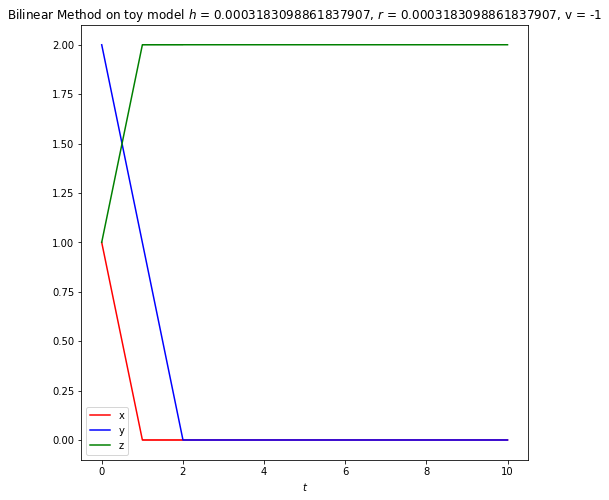

In [470]:
# Initial value
x0 = 1,2,1
# Max time
T = 10
# time step (h in the notes)
tstep = 10**-3/np.pi
# Length of time interval averaged over
r =  tstep*1
# z component of vector field in R2 and R3
v = -1
# Number of iterations
n = int(T/tstep)

tt = np.linspace(0, T, n)
yyy = bi_model(tstep,T,r,v,x0,solve_method='nr')

fig, ax = plt.subplots(1, figsize=defaultfigsize)
# Plots of each component of particle over time
ax.plot(tt, yyy[:,0],color = xcolor,label='x')
ax.plot(tt, yyy[:,1],color = ycolor,label='y')
ax.plot(tt, yyy[:,2],color = zcolor,label='z')
ax.set_xlabel('$t$')
plt.title("Bilinear Method on toy model $h$ = {}, $r$ = {}, v = {}".format(tstep,r,v))
ax.legend()

Text(0, 0.5, 'y')

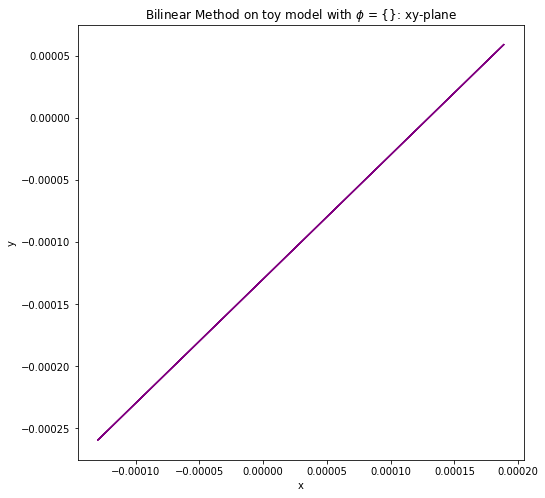

In [8]:
# Values come from previous simulation
plt.figure(figsize=defaultfigsize)
# Plot of y over x as it orbits around \Sigma
plt.plot(yyy[int(2*n/T):-1,0],yyy[int(2*n/T):-1,1],'-',color = xycolor)
plt.title("Bilinear Method on toy model with $\phi$ = {}: xy-plane")
plt.xlabel('x')
plt.ylabel('y')

# Time Delay Method

In [85]:
def values_before_zero(t,x0 = (1,2,1)):
    # The initial trajectory is assumed to be stationary WLOG
    x = np.array(x0)
    return x

integrands = [fx,fy,fz]

def integrate_avg(yy,t,delta,v):
    # Gives the average direction that we should follow for when D is greater than or less than t0
    
    def integral(inte,int_range,t_range,v):
        # Gives average of the vector fields visited between t-delta and t
        vector_field_over_last_t_minus_delta = np.apply_along_axis(lambda x : inte(x,v = v),1,int_range) 
        
        return np.sum(vector_field_over_last_t_minus_delta,axis = 0)/len(int_range)
    
    # i = position of t in tt
    if len(np.where(tt == t)) == 0:
        raise Exception('No such value of t in tt')
    i = np.where(tt == t)[0][0]
    # j = position of t-delta in tt (rounded). This is D in the notes
    j = np.argmin(np.abs((t-delta) - tt))
    
    # If t - delta is less than the lowest in tt, we have to create new values from the initial trajectory
    difference = tt[0] - (t- delta) 

    if difference >= 0:
        # t - delta is less than t0, so we generate values using values_before_zero
        prev_time = np.arange(t-delta, tstep ,tstep) # Time range before zero
        prev_vals = np.row_stack([values_before_zero(t) for t in prev_time]) # Values before zero
        
        time_range = np.hstack((prev_time,tt[0:i])) # All the time values in the relevant range (t-delta up to t) 
        integration_range = np.vstack((prev_vals,yy[0:i])) # The actual values of the particle over the relevant time

        avgs = []
        for inte in integrands:
            avgs +=  [integral(inte,integration_range,time_range,v)]
        return np.array(avgs)

    elif difference < 0:
        # t - delta is greater than t0, so we use previously computed positions to get new direction
        time_range = tt[j:i]
        integration_range = yy[j:i]

        avgs = []
        for inte in integrands:
            avgs +=  [integral(inte,integration_range,time_range,v)]
        return np.array(avgs)

def time_delay_model(tstep,T,delta,v,x0=(1,2,1)):
    n = int(T/tstep)
    yy = np.zeros((n,len(values_before_zero(0)))) + values_before_zero(0,x0)
    tt = np.linspace(0, T, n)

    for i,t in enumerate(tqdm(tt,position=0,leave = False,desc = 'Time delay model')):
        # Get average of velocities from t - delta to t
        velocity = integrate_avg(yy,t,delta,v)
        # Use Euler method from this average to get next point
        yy[i,:] = yy[i-1,:] + tstep*velocity
    return yy

Single Simulation

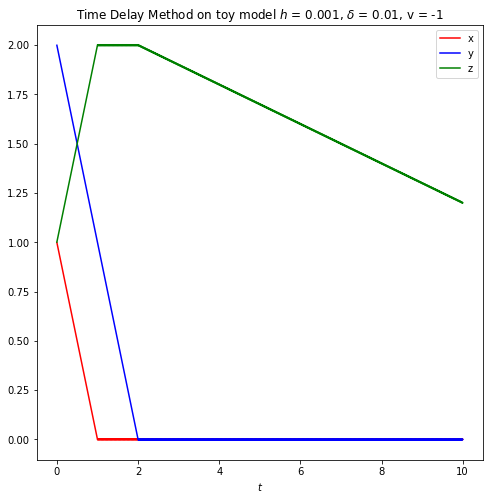

In [97]:
# Initial value
x0 = 1,2,1
# Max time
T = 10
# time step (h in the notes)
tstep = 10**-3#10**-4 /np.pi
# Length of time interval averaged over
delta =  10*tstep#0.018461538461538464#10**-3*(1+0.011)#
# z component of vector field in R2 and R3
v = -1
# Number of iterations
n = int(T/tstep)

tt = np.linspace(0, T, n)
yyy = time_delay_model(tstep,T,delta,v,x0)

fig, ax = plt.subplots(1, figsize=defaultfigsize)
# Plots of each component of particle over time
ax.plot(tt, yyy[:,0],color = xcolor,label='x')
ax.plot(tt, yyy[:,1],color = ycolor,label='y')
ax.plot(tt, yyy[:,2],color = zcolor,label='z')
ax.set_xlabel('$t$')
plt.title("Time Delay Method on toy model $h$ = {}, $\delta$ = {}, v = {}".format(tstep,delta,v))
ax.legend()

Plot of motion in $xy$-plane

Text(0, 0.5, 'y')

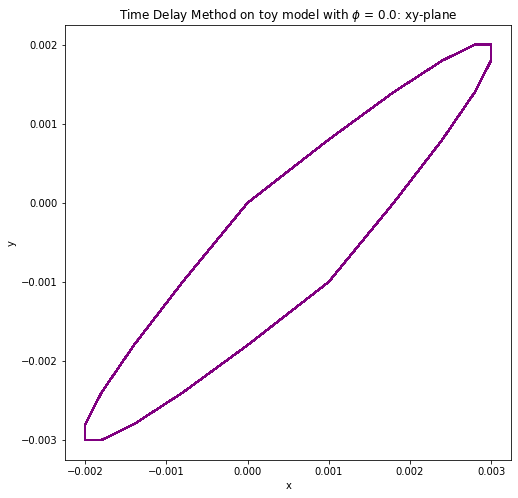

In [101]:
phi = 1/(2*delta) -int(1/(2*delta))
# Values come from previous simulation
plt.figure(figsize=defaultfigsize)
# Plot of y over x as it orbits around \Sigma
plt.plot(yyy[int(2*n/T):-1,0],yyy[int(2*n/T):-1,1],'-',color = xycolor)
plt.title("Time Delay Method on toy model with $\phi$ = {}: xy-plane".format(phi))
plt.xlabel('x')
plt.ylabel('y')

Close-up of oscillatory\sliding behaviour

Text(0.5, 1.0, 'Zoomed behaviour for $h$ = 0.001, $\\delta$ = 0.01, v = -1')

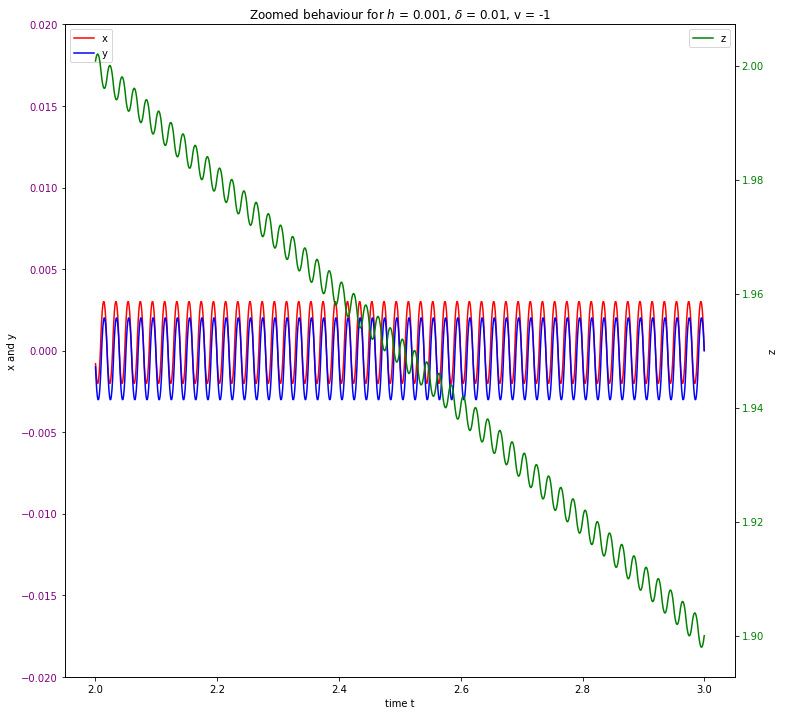

In [137]:
tmin, tmax = 2,3
xymin, xymax = -2*delta,2*delta

zoom1,zoom2 = int(tmin*n/T),int(tmax*n/T)

fig,ax1 = plt.subplots(figsize = (12,12))
ax1.plot(tt[zoom1:zoom2], yyy[zoom1:zoom2,0],color = xcolor,label='x')
ax1.plot(tt[zoom1:zoom2], yyy[zoom1:zoom2,1],color = ycolor,label='y')
ax1.set_ylim(xymin, xymax) 
ax1.set_ylabel('x and y')

ax1.legend(loc = 'upper left')
ax1.tick_params(axis='y',labelcolor=xycolor)

ax2 = ax1.twinx()
ax2.plot(tt[zoom1:zoom2], yyy[zoom1:zoom2,2],color = zcolor,label='z')
ax2.legend(loc =0)
ax2.tick_params(axis='y',labelcolor=zcolor)
ax2.set_ylabel('z')

ax1.set_xlabel('time t')
plt.title("Zoomed behaviour for $h$ = {}, $\delta$ = {}, v = {}".format(tstep,delta,v))

### Toy Model Proof

$\phi \in [0,\frac{1}{2}]$

In [380]:
# Initial value
x0 = 1,2,1
# Max time
T = 5
# time step (h in the notes)
tstep = 10**-3
# Length of time interval averaged over
delta_phi1 =  0.06060606
# z component of vector field in R2 and R3
v = -1
# Number of iterations
n = int(T/tstep)

phi1 = 1/(2*delta_phi1) - int(1/(2*delta_phi1))

tt = np.linspace(0, T, n)
yyy_phi1 = time_delay_model(tstep,T,delta_phi1,v,x0)

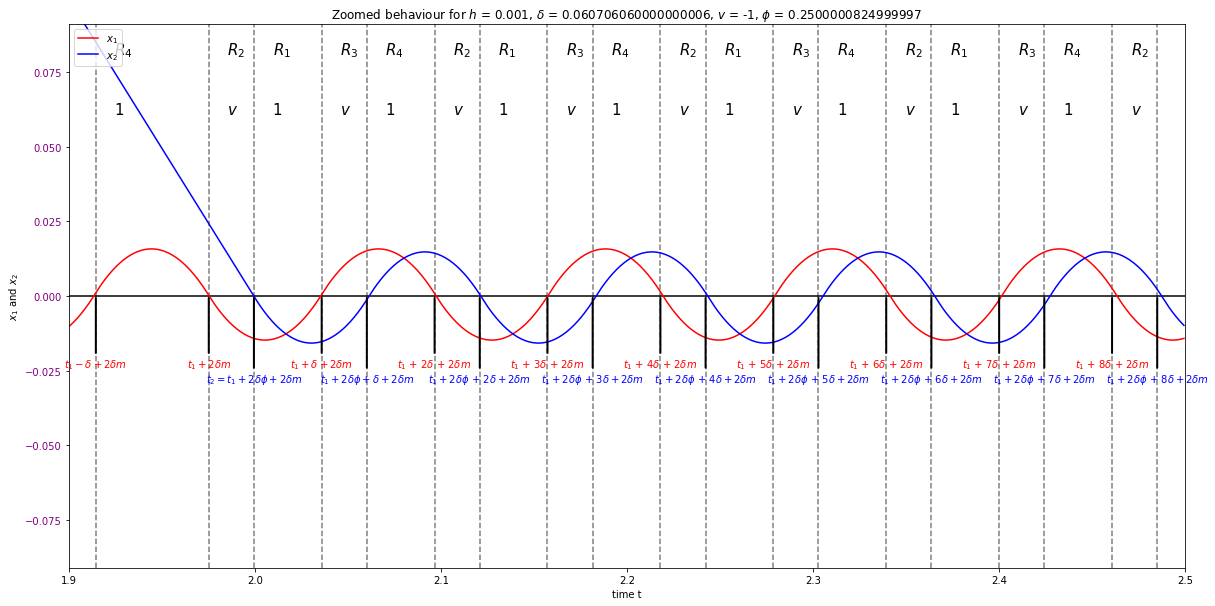

In [438]:
delta_phi1 =  0.06060606
tmin, tmax = 1.9,2.5
xymin, xymax = -1.5*delta_phi1,1.5*delta_phi1
delta_phi1_t1_error = 0.0001
delta_phi1 += delta_phi1_t1_error

zoom1,zoom2 = int(tmin*n/T),int(tmax*n/T)

fig, ax1 = plt.subplots(figsize = ((20,10)))
ax1.plot(tt[zoom1:zoom2], yyy_phi1[zoom1:zoom2,0],color = xcolor,label='$x_1$')
ax1.plot(tt[zoom1:zoom2], yyy_phi1[zoom1:zoom2,1],color = ycolor,label='$x_2$')
ax1.set_ylim(xymin, xymax) 
ax1.set_ylabel('$x_1$ and $x_2$')

ax1.legend(loc = 'upper left')
ax1.tick_params(axis='y',labelcolor=xycolor)
ax1.set_xlabel('time t')
plt.title("Zoomed behaviour for $h$ = {}, $\delta$ = {}, $v$ = {}, $\phi$ = {}".format(tstep,delta_phi1,v,phi1))

plt.hlines(xmin=tmin,xmax = tmax, y=0, color = 'black')
ax1.margins(x=0,y=0)
t11 = 1.9145
t21 = 2
t1s1 = [t11 + i*delta_phi1 for i in range(10)]
t2s1 = [t11 + (i+.9)*delta_phi1 + 2*delta_phi1*phi1 for i in range(9)]
t1_labels1 = ["$t_1 - \delta+ 2\delta m $"]+ ['$t_1 + 2\delta m$']+[
                '$t_1 + \delta+ 2\delta m $']+ ["$t_1$ + {}$\delta$ + $2\delta m$".format(i) for i in range(2,10)]
t2_labels1 = ["$t_2 = t_1 + 2\delta\phi+ 2\delta m $"]+['$t_1 + 2\delta\phi +\delta+ 2\delta m $']+["$t_1 + 2\delta\phi$ + {}$\delta+ 2\delta m $".format(i) for i in range(2,10)]
t1_height1 = - 0.02
t2_height1 = - 0.03

labellings1 = [[t1s1,t1_labels1,xcolor,t1_height],[t2s1,t2_labels1,ycolor,t2_height]]

fontsizer = 10
tickwidth = 2

for labelling in labellings1:
    tis,ti_labels,coloring,ti_height = [*labelling]
    for ti,ti_label in zip(tis,ti_labels):
        ax1.annotate(ti_label, xy=(ti, 0), xytext=(ti, ti_height), c = coloring,xycoords ='data',
            fontsize=fontsizer, ha='center', va='bottom',
            arrowprops=dict(arrowstyle='-',
                            connectionstyle=connstyle, lw=tickwidth,color = 'black'))
ordered_all_tis1 = sorted(t1s1 + t2s1)
Ri_sequence1 = [4,2,1,3]*4 + [4,2]
Ris1 = ['$R_{}$'.format(i) for i in Ri_sequence1]
Ri_fontsizer1 = 15
region_x_offset1 = 0.01

for ti,Ri in zip(ordered_all_tis1,Ris1):
    ax1.annotate(Ri, xy = (ti+region_x_offset1,xymax - 0.01),fontsize = Ri_fontsizer1)
    if Ri == '$R_2$' or Ri == '$R_3$':
        ax1.annotate('$v$', xy = (ti+region_x_offset1,xymax - 0.03),fontsize = Ri_fontsizer1)
    elif Ri == '$R_1$' or Ri == '$R_4$':
        ax1.annotate('1', xy = (ti+region_x_offset1,xymax - 0.03),fontsize = Ri_fontsizer1)

plt.vlines(x=t1s1, ymin=xymin, ymax=xymax,linestyle='--',alpha = 0.5)
plt.vlines(x=t2s1, ymin=xymin, ymax=xymax,linestyle='--',alpha = 0.5)

$\phi \in [\frac{1}{2},1]$

In [431]:
# Initial value
x0 = 1,2,1
# Max time
T = 5
# time step (h in the notes)
tstep = 10**-3
# Length of time interval averaged over
delta_phi2 =  0.07407407
# z component of vector field in R2 and R3
v = -1
# Number of iterations
n = int(T/tstep)

phi2 = 1/(2*delta_phi2) - int(1/(2*delta_phi2))

tt = np.linspace(0, T, n)
yyy_phi2 = time_delay_model(tstep,T,delta_phi2,v,x0)

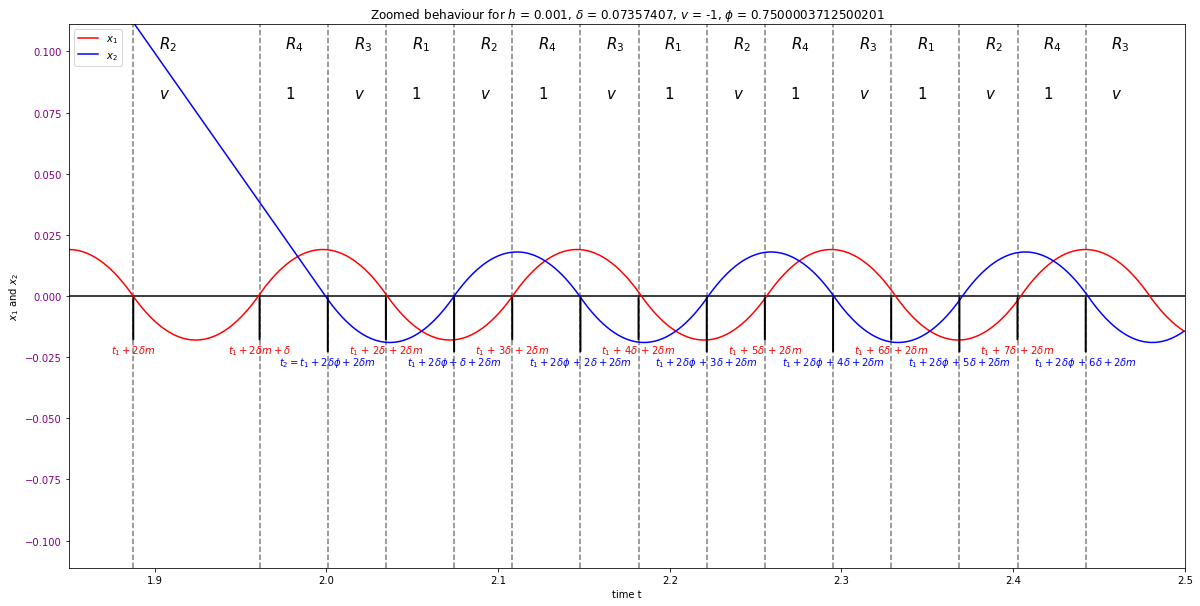

In [439]:
delta_phi2 =  0.07407407
tmin, tmax = 1.85,2.5
xymin, xymax = -1.5*delta_phi2,1.5*delta_phi2
delta_phi2_t1_error = -0.0005
delta_phi2 += delta_phi2_t1_error

zoom1,zoom2 = int(tmin*n/T),int(tmax*n/T)

fig, ax1 = plt.subplots(figsize = ((20,10)))
ax1.plot(tt[zoom1:zoom2], yyy_phi2[zoom1:zoom2,0],color = xcolor,label='$x_1$')
ax1.plot(tt[zoom1:zoom2], yyy_phi2[zoom1:zoom2,1],color = ycolor,label='$x_2$')
ax1.set_ylim(xymin, xymax) 
ax1.set_ylabel('$x_1$ and $x_2$')

ax1.legend(loc = 'upper left')
ax1.tick_params(axis='y',labelcolor=xycolor)
ax1.set_xlabel('time t')
plt.title("Zoomed behaviour for $h$ = {}, $\delta$ = {}, $v$ = {}, $\phi$ = {}".format(tstep,delta_phi2,v,phi2))

plt.hlines(xmin=tmin,xmax = tmax, y=0, color = 'black')
ax1.margins(x=0,y=0)
t12 = 1.8875
t22 = 2
t1s2 = [t12 + i*delta_phi2 for i in range(8)]
t2s2 = [t12 + (i+0.04)*delta_phi2 + 2*delta_phi2*phi2 for i in range(7)]
t1_labels2 = ["$t_1 + 2\delta m$"]+ ['$t_1 + 2\delta m +\delta$']+["$t_1$ + {}$\delta$ + $2\delta m$".format(i) for i in range(2,10)]
t2_labels2 = ["$t_2 = t_1 + 2\delta\phi+ 2\delta m $"]+['$t_1 + 2\delta\phi +\delta+ 2\delta m $']+["$t_1 + 2\delta\phi$ + {}$\delta+ 2\delta m $".format(i) for i in range(2,10)]
t1_height = - 0.025
t2_height = - 0.03

labellings2 = [[t1s2,t1_labels2,xcolor,t1_height],[t2s2,t2_labels2,ycolor,t2_height]]

fontsizer = 10
tickwidth = 2

for labelling in labellings2:
    tis,ti_labels,coloring,ti_height = [*labelling]
    for ti,ti_label in zip(tis,ti_labels):
        ax1.annotate(ti_label, xy=(ti, 0), xytext=(ti, ti_height), c = coloring,xycoords ='data',
            fontsize=fontsizer, ha='center', va='bottom',
            arrowprops=dict(arrowstyle='-',
                            connectionstyle=connstyle, lw=tickwidth,color = 'black'))
ordered_all_tis2 = sorted(t1s2 + t2s2)
Ri_sequence2 = [2,4,3,1]*3 + [2,4,3]
Ris2 = ['$R_{}$'.format(i) for i in Ri_sequence2]
Ri_fontsizer2 = 15
region_x_offset2 = 0.015

for ti,Ri in zip(ordered_all_tis2,Ris2):
    ax1.annotate(Ri, xy = (ti+region_x_offset2,xymax - 0.01),fontsize = Ri_fontsizer2)
    if Ri == '$R_2$' or Ri == '$R_3$':
        ax1.annotate('$v$', xy = (ti+region_x_offset2,xymax - 0.03),fontsize = Ri_fontsizer2)
    elif Ri == '$R_1$' or Ri == '$R_4$':
        ax1.annotate('1', xy = (ti+region_x_offset2,xymax - 0.03),fontsize = Ri_fontsizer2)

plt.vlines(x=t1s2, ymin=xymin, ymax=xymax,linestyle='--',alpha = 0.5)
plt.vlines(x=t2s2, ymin=xymin, ymax=xymax,linestyle='--',alpha = 0.5)

Final $z$ gradient for varying $\phi$ and $v$

In [21]:
def anal_doty3(v,phi):
    # Expected final gradient of z from analysis
    if 0 <= phi <= .5:
        return 1 + 2*phi*(v-1)
    elif .5 <= phi <= 1:
        return -1 + 2*(phi + v - phi*v)
    
def nume_doty3(yy,tstart= 2.1):
    # Actual numeric final gradient of z 
    return (yy[-1,2] - yy[int(n*tstart/T),2])/(tt[-1] - tt[int(n*tstart/T)])

In [454]:
tstep = 10**-4 # Time step
phi_num = 20 # Number of phis
v_num = 20 # Number of vs
# Max time
T = 3
n = int(T/tstep)
# Time range
tt = np.linspace(0, T, n)
# Time which the numerical gradient is measured from
tstart = T - .9
# Initial value
x0 = (1,2,1)

# Upper bound on deltas
delta_max = .15
# Values of delta which should give equally spaced phis
D = int(1 / (2*delta_max))
deltas = np.array([phi_num/(2*(phi_num)*(phi_num*D+1))]+[phi_num/(2*n*(phi_num*D+1)) for n in range(1,phi_num)])
print('deltas=',deltas)
# Values of phi
phis = 1/(2*deltas) - np.floor(1/(2*deltas))
print('phis =',phis)

# Values of v
vs = np.linspace(-1,1,v_num)
doty3s = np.zeros((len(deltas),len(vs),2))

# Initialise simulations
yys = np.zeros((len(deltas),len(vs),n,len(x0)))

# Vary v
for i,vi in enumerate(vs):
    #clear_output(wait=True)
    print('{}th v / {}'.format(i+1,v_num))
    # Vary phi
    for deltaj,(j,phij) in zip(deltas,enumerate(phis)):
        yyji = time_delay_model(tstep,T,deltaj,vi,x0)
        # Compute and store the resultant numerical z gradient
        doty3s[j,i,0] = nume_doty3(yyji,tstart = tstart)
        # Simultaneously store the analytically expected z gradient
        doty3s[j,i,1] = anal_doty3(vi,phij)
        yys[j,i,:,:] = yyji

# Plot results
V,P = np.meshgrid(vs,phis)
fig, [ax1,ax2] = plt.subplots(1,2, figsize=largerfigsize,sharey=True)
cm = col.LinearSegmentedColormap('viridis', 1024)

# min and max for the colourbar
vmin,vmax = np.min(doty3s[:,:,:]),np.max(doty3s[:,:,:])

nume_results = ax1.scatter(V,P,c = doty3s[:,:,0],vmin=vmin,vmax=vmax,marker = 's',s = plt.rcParams['lines.markersize']**2*5)
ax1.set_title('Plot of actual final gradient of $z$ against $v$ and $\phi$')
ax1.set_xlabel('v')
ax1.set_ylabel('$\phi$')

anal_results = ax2.scatter(V,P,c = doty3s[:,:,1],vmin=vmin,vmax=vmax,marker = 's',s = plt.rcParams['lines.markersize']**2*5)
ax2.set_title('Plot of expected final gradient of $z$ against $v$ and $\phi$')
ax2.set_xlabel('v')
ax2.set_ylabel('$\phi$')

fig.colorbar(anal_results,ax=ax2)
fig.colorbar(nume_results,ax=ax1)
fig.show()

deltas= [0.00819672 0.16393443 0.08196721 0.05464481 0.04098361 0.03278689
 0.0273224  0.0234192  0.0204918  0.01821494 0.01639344 0.01490313
 0.0136612  0.01261034 0.0117096  0.01092896 0.0102459  0.0096432
 0.00910747 0.00862813]
phis = [0.   0.05 0.1  0.15 0.2  0.25 0.3  0.35 0.4  0.45 0.5  0.55 0.6  0.65
 0.7  0.75 0.8  0.85 0.9  0.95]
1th v / 20


Time delay model:  85%|████████████████████████████████████████████████▎        | 25454/30000 [04:12<00:43, 104.76it/s]

KeyboardInterrupt: 

work around to second delta being too large

In [ ]:
tstep = 10**-3  # Time step
phi_num = 20 # Number of phis
square_size = 10
v_num = 20 # Number of vs
# Max time
T = 3
n = int(T/tstep)
# Time range
tt = np.linspace(0, T, n)
# Time which the numerical gradient is measured from
tstart = T - .9
# Initial value
x0 = (1,2,1)

# Upper bound on deltas
delta_max = .1
# Values of delta which should give equally spaced phis
D = int(1 / (2*delta_max))
deltas = np.array([phi_num/(2*(phi_num)*(phi_num+1))]+[phi_num/(2*n*(phi_num+1)) for n in range(1,phi_num)])

#deltas[1] = 0.04149
#deltas[2] = 0.04131
#deltas[3] = 0.04115


print('deltas=',deltas)
# Values of phi
phis = 1/(2*deltas) - np.floor(1/(2*deltas))
print('phis =',phis)

# Values of v
vs = np.linspace(-1,1,v_num)
doty3s = np.zeros((len(deltas),len(vs),2))

# Initialise simulations
yys = np.zeros((len(deltas),len(vs),n,len(x0)))

# Vary v
for i,vi in enumerate(vs):
    #clear_output(wait=True)
    print('{}th v / {}'.format(i+1,v_num))
    # Vary phi
    for deltaj,(j,phij) in zip(deltas,enumerate(phis)):
        yyji = time_delay_model(tstep,T,deltaj,vi,x0)
        # Compute and store the resultant numerical z gradient
        doty3s[j,i,0] = nume_doty3(yyji,tstart = tstart)
        # Simultaneously store the analytically expected z gradient
        doty3s[j,i,1] = anal_doty3(vi,phij)
        yys[j,i,:,:] = yyji

# Plot results
V,P = np.meshgrid(vs,phis)
fig, [ax1,ax2] = plt.subplots(1,2, figsize=largerfigsize,sharey=True)
cm = col.LinearSegmentedColormap('viridis', 1024)

# min and max for the colourbar
vmin,vmax = np.min(doty3s[:,:,:]),np.max(doty3s[:,:,:])

nume_results = ax1.scatter(V,P,c = doty3s[:,:,0],vmin=vmin,vmax=vmax,marker = 's',s = plt.rcParams['lines.markersize']**2*square_size)
ax1.set_title('Plot of actual final gradient of $z$ against $v$ and $\phi$')
ax1.set_xlabel('v')
ax1.set_ylabel('$\phi$')

anal_results = ax2.scatter(V,P,c = doty3s[:,:,1],vmin=vmin,vmax=vmax,marker = 's',s = plt.rcParams['lines.markersize']**2*square_size)
ax2.set_title('Plot of expected final gradient of $z$ against $v$ and $\phi$')
ax2.set_xlabel('v')
ax2.set_ylabel('$\phi$')

fig.colorbar(anal_results,ax=ax2)
fig.colorbar(nume_results,ax=ax1)
fig.show()

deltas= [0.02380952 0.47619048 0.23809524 0.15873016 0.11904762 0.0952381
 0.07936508 0.06802721 0.05952381 0.05291005 0.04761905 0.04329004
 0.03968254 0.03663004 0.03401361 0.03174603 0.0297619  0.0280112
 0.02645503 0.02506266]
phis = [0.   0.05 0.1  0.15 0.2  0.25 0.3  0.35 0.4  0.45 0.5  0.55 0.6  0.65
 0.7  0.75 0.8  0.85 0.9  0.95]
1th v / 20


2th v / 20


3th v / 20


4th v / 20


5th v / 20


6th v / 20


7th v / 20


8th v / 20


Time delay model:  52%|██████████████████████████████▉                             | 1546/3000 [17:17<01:01, 23.58it/s]